# Comparing DEMNAS and NASA DEM

# Table of contents
* [Set-up caching proxy and dask cluster](#Set-up-caching-proxy-and-dask-cluster)
* [Initialise Datacube](#Initialise-Datacube)
* [Fetch data for the Lake Tempe region](#Fetch-data-for-the-Lake-Tempe-region)
* [Plot both DEMs side-by-side](#Plot-both-DEMs-side-by-side)
* [Compute and plot differences](#Compute-and-plot-differences)


## Set-up caching proxy and dask cluster

In [1]:
from os import environ

environ["AWS_HTTPS"] = "NO"
environ["GDAL_HTTP_PROXY"] = "easi-caching-proxy.caching-proxy:80"
print(f'Will use caching proxy at: {environ.get("GDAL_HTTP_PROXY")}')

Will use caching proxy at: easi-caching-proxy.caching-proxy:80


In [2]:
from os import environ
from urllib.parse import urlparse
from dask.distributed import Client, LocalCluster
from IPython.core.display import HTML

cluster = LocalCluster(scheduler_port=0, dashboard_address=":0")
client = Client(cluster)
# display(cluster)
if cluster:
    port = urlparse(cluster.dashboard_link).port
    dashboard_url = (
        f'https://hub.sg-dev.easi-eo.solutions/'
        f'{environ["JUPYTERHUB_SERVICE_PREFIX"]}proxy/{port}/status'
    )
    display(HTML(f'Dashboard: <a href={dashboard_url}>{dashboard_url}</a>'))

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/git/datacube-notebooks/Ronnie/dask-worker-space/worker-z666cpeq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/git/datacube-notebooks/Ronnie/dask-worker-space/worker-c8chsmnp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/git/datacube-notebooks/Ronnie/dask-worker-space/worker-xfoknxc_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/git/datacube-notebooks/Ronnie/dask-worker-space/worker-f1k57tl4', purging


## Initialise Datacube
The NASA DEM and DEMNAS have been indexed in different DBs so we create two distinct Datacube instances to read from them.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datacube import Datacube
from datacube.utils.aws import configure_s3_access

configure_s3_access(
    aws_unsigned=False, 
    requester_pays=True, 
    client=client,
);

dc = Datacube(env="odc-tai031")
dc_main = Datacube()

In [4]:
# Display available products in personal DB
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
demnas,demnas,DEMNAS,None,None,None
lpdaac_nasadem,lpdaac_nasadem,NASADEM Merged DEM Global 1 arc second V001,None,None,None
lpdaac_nasadem_sc,lpdaac_nasadem_sc,NASADEM Slope and Curvature Global 1 arc second,None,None,None
srtm_dem1sv1_0,srtm_dem1sv1_0,DEM 1sec Version 1.0,None,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...","(-0.00027777777778, 0.00027777777778)"
usgs_aws_ls8c2_sr,usgs_aws_ls8c2_sr,Landsat 8 USGS Collection 2 Surface Reflectanc...,None,None,None


In [5]:
# Display available products in main DB
dc_main.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
copernicus_dem_30,copernicus_dem_30,Copernicus 30m Digital Elevation Model (GLO-30),None,None,None
landsat5_c2l2_sr,landsat5_c2l2_sr,Landsat 5 Collection 2 Level-2 Surface Reflect...,None,None,None
landsat7_c2l2_sr,landsat7_c2l2_sr,Landsat 7 USGS Collection 2 Surface Reflectanc...,None,None,None
landsat8_c2l2_sr,landsat8_c2l2_sr,"Landsat 8 Collection 2 Surface Reflectance, pr...",None,None,None
lpdaac_nasadem,lpdaac_nasadem,NASADEM Merged DEM Global 1 arc second V001,None,None,None
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed...",None,None,None


## Fetch data for the Lake Tempe region

In [6]:
product = "demnas"

# # Broader region around Lake Tempe
# longitude = (119.570582, 120.041621)
# latitude = (-4.466466, -3.882999)

# Lake Tempe
longitude = (119.8242517, 120.0350519)
latitude = (-4.2013799, -3.9445384)

params = {
    "latitude": latitude,
    "longitude": longitude,
    "output_crs": "EPSG:4326", 
    "resolution": (-1/3600, 1/3600),
    "dask_chunks": {'time': 1},
}

In [7]:
demnas = dc.load(product=product, **params)
elevation_demnas = demnas.elevation.squeeze().where(demnas.elevation >= -100)
elevation_demnas.persist();
min_demnas = np.nanmin(elevation_demnas)
max_demnas = np.nanmax(elevation_demnas)
print(f"Min: {min_demnas}, max: {max_demnas}")

Min: 1.4133386611938477, max: 230.64585876464844


In [8]:
nasadem = dc_main.load(product="lpdaac_nasadem", **params)
elevation_nasadem = nasadem.elevation.squeeze().where(nasadem.elevation >= -100)
elevation_nasadem.persist();
min_nasadem = np.nanmin(elevation_nasadem)
max_nasadem = np.nanmax(elevation_nasadem)
print(f"Min: {min_nasadem}, max: {max_nasadem}")

Min: -17.0, max: 235.0


## Plot both DEMs side-by-side

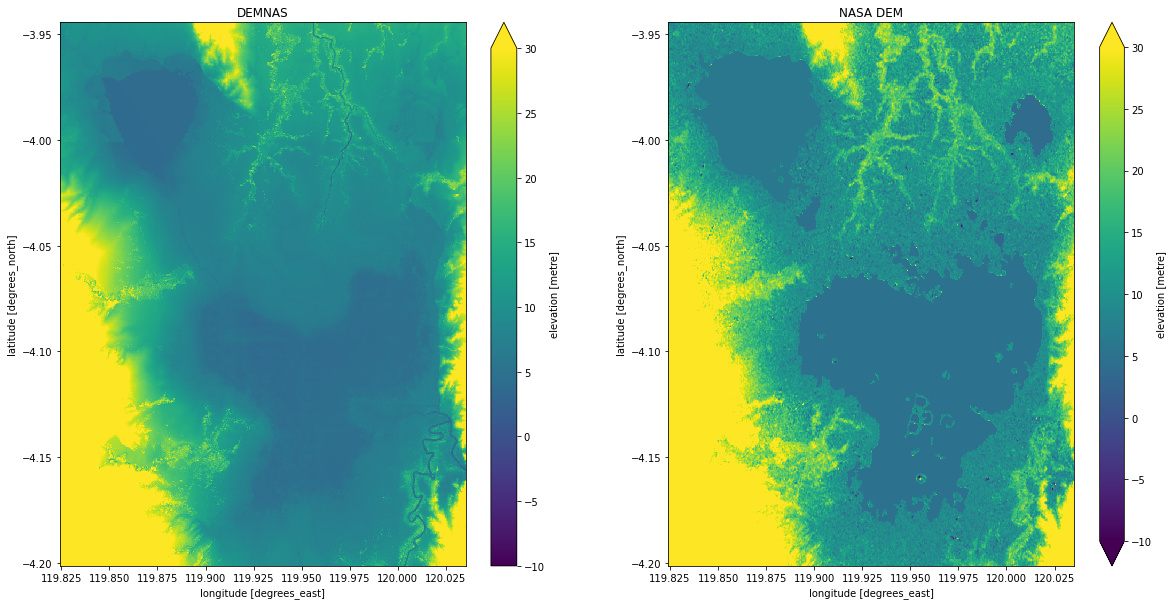

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

min_all = min(min_demnas, min_nasadem)
max_all = max(max_demnas, max_nasadem)  
# Manually setting values for better visual effect
min_all = -10
max_all = 30

elevation_demnas.plot(ax=axes[0], vmin=min_all, vmax=max_all);
axes[0].set_title("DEMNAS");

elevation_nasadem.plot(ax=axes[1], vmin=min_all, vmax=max_all);
axes[1].set_title("NASA DEM");

## Compute and plot differences

Min: -46.544514656066895, max: 30.490325927734375, mean: -1.8414678923246022


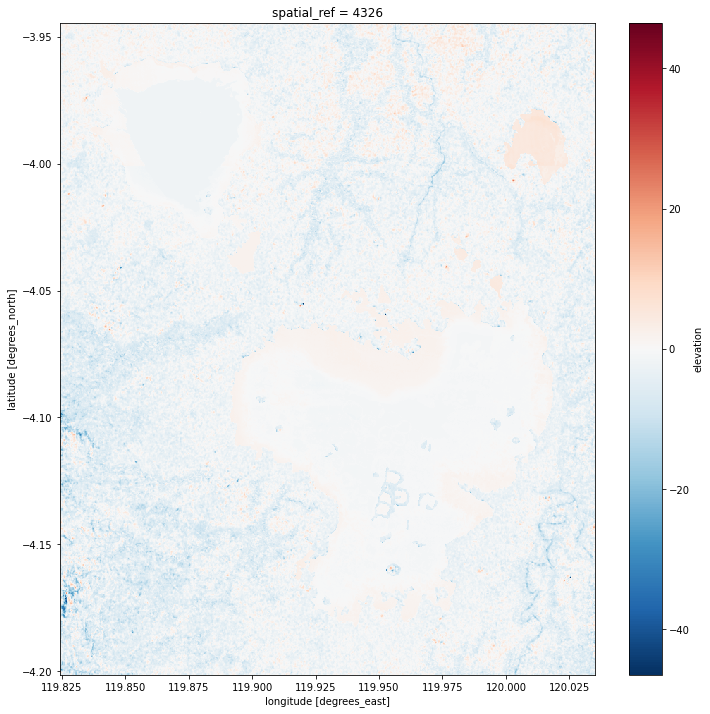

In [10]:
elevation_diff = elevation_demnas.squeeze() - elevation_nasadem.squeeze()
elevation_diff.plot(figsize=(12, 12));
diff = elevation_diff.values
print(f"Min: {np.nanmin(diff)}, max: {np.nanmax(diff)}, mean: {np.nanmean(diff)}")